# IMPORT LIBRARIES

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# ACQUIRE LIVE DATA

In [3]:
stock_symbol = 'RELIANCE.NS'
data = yf.download(tickers=stock_symbol, start= '2013-04-17', end = '2023-04-21', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-04-17 00:00:00+05:30,399.141541,400.998932,380.988617,383.217468,356.972443,14816785
2013-04-18 00:00:00+05:30,384.604340,388.913483,382.697418,387.130402,360.617401,6365615
2013-04-22 00:00:00+05:30,389.309723,393.618896,385.495880,391.167114,364.377625,5902995
2013-04-23 00:00:00+05:30,392.033905,399.116760,389.334503,398.076630,370.813965,5702397
2013-04-25 00:00:00+05:30,400.008331,409.419128,400.008331,405.976746,378.172943,11962780


In [5]:
len(data)

2467

In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-13 00:00:00+05:30,2353.000000,2365.800049,2342.000000,2355.500000,2355.500000,5712541
2023-04-17 00:00:00+05:30,2424.949951,2424.949951,2349.050049,2367.449951,2367.449951,8274452
2023-04-18 00:00:00+05:30,2377.000000,2377.000000,2326.000000,2340.350098,2340.350098,4802172
2023-04-19 00:00:00+05:30,2339.050049,2357.899902,2332.199951,2352.000000,2352.000000,5664207
2023-04-20 00:00:00+05:30,2354.100098,2359.000000,2332.100098,2346.050049,2346.050049,3233882


# DATA VISUALIZATION

<AxesSubplot:xlabel='Date'>

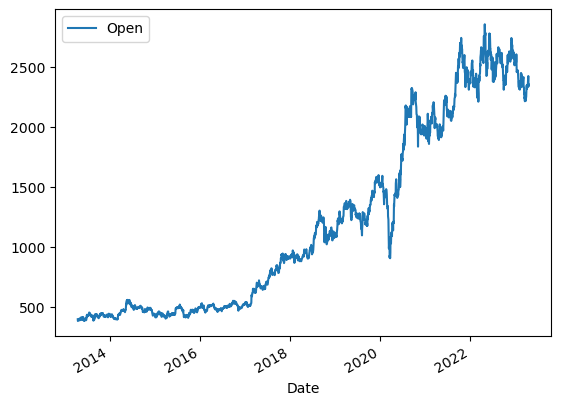

In [8]:
opn = data[['Open']]
opn.plot()

In [9]:
ds = opn.values
ds

array([[ 399.14154053],
       [ 384.6043396 ],
       [ 389.3097229 ],
       ...,
       [2377.        ],
       [2339.05004883],
       [2354.10009766]])

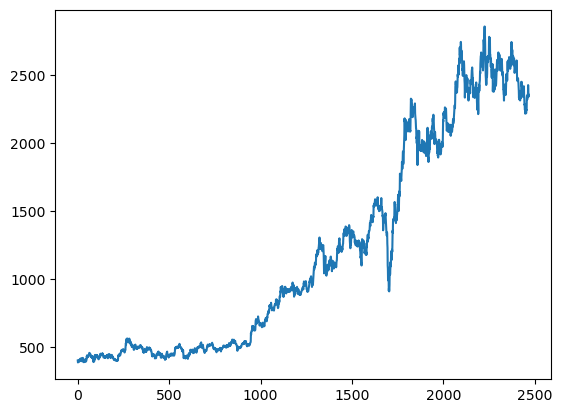

In [10]:
plt.plot(ds)

# DATA NORMALIZATION

In [11]:
from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [12]:
len(ds_scaled), len(ds)

(2467, 2467)

# TRAIN-TEST SPLIT

In [13]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size
train_size,test_size

(1726, 741)

In [14]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]
len(ds_train),len(ds_test)

(1726, 741)

# CREATING SLIDING WINDOW

In [16]:
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [17]:
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [18]:
X_train.shape,y_train.shape
X_test.shape, y_test.shape

((640, 100), (640,))

In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# LSTM MODEL 

In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [22]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 50)           2

In [23]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
26/26 [==============================] - 33s 482ms/step - loss: 0.0081 - val_loss: 0.0263
Epoch 2/100
26/26 [==============================] - 9s 338ms/step - loss: 0.0016 - val_loss: 0.0441
Epoch 3/100
26/26 [==============================] - 9s 353ms/step - loss: 0.0012 - val_loss: 0.0656
Epoch 4/100
26/26 [==============================] - 9s 348ms/step - loss: 0.0012 - val_loss: 0.0556
Epoch 5/100
26/26 [==============================] - 9s 358ms/step - loss: 0.0012 - val_loss: 0.0500
Epoch 6/100
26/26 [==============================] - 9s 356ms/step - loss: 0.0013 - val_loss: 0.0382
Epoch 7/100
26/26 [==============================] - 9s 345ms/step - loss: 0.0011 - val_loss: 0.0490
Epoch 8/100
26/26 [==============================] - 9s 347ms/step - loss: 0.0011 - val_loss: 0.0394
Epoch 9/100
26/26 [==============================] - 9s 351ms/step - loss: 0.0011 - val_loss: 0.0479
Epoch 10/100
26/26 [==============================] - 9s 339ms/step - loss: 0.0010 - val_l

26/26 [==============================] - 18s 689ms/step - loss: 4.6171e-04 - val_loss: 0.0079
Epoch 79/100
26/26 [==============================] - 18s 702ms/step - loss: 4.6376e-04 - val_loss: 0.0157
Epoch 80/100
26/26 [==============================] - 18s 694ms/step - loss: 3.8893e-04 - val_loss: 0.0073
Epoch 81/100
26/26 [==============================] - 18s 697ms/step - loss: 4.3356e-04 - val_loss: 0.0065
Epoch 82/100
26/26 [==============================] - 17s 663ms/step - loss: 3.8600e-04 - val_loss: 0.0125
Epoch 83/100
26/26 [==============================] - 18s 709ms/step - loss: 3.7227e-04 - val_loss: 0.0110
Epoch 84/100
26/26 [==============================] - 18s 685ms/step - loss: 3.6931e-04 - val_loss: 0.0128
Epoch 85/100
26/26 [==============================] - 18s 698ms/step - loss: 3.8971e-04 - val_loss: 0.0163
Epoch 86/100
26/26 [==============================] - 18s 701ms/step - loss: 3.5984e-04 - val_loss: 0.0079
Epoch 87/100
26/26 [==============================

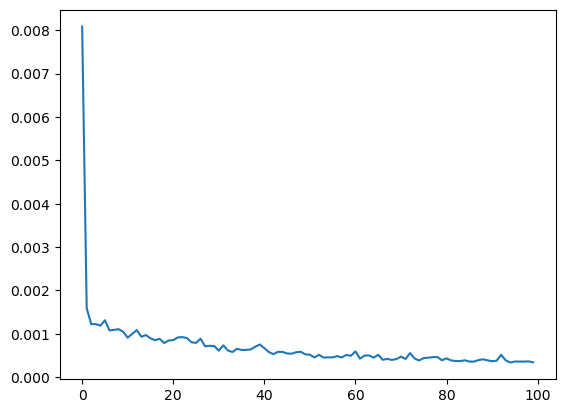

In [24]:
loss = model.history.history['loss']
plt.plot(loss)

In [106]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

20/20 [==============================] - 2s 109ms/step


In [107]:
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

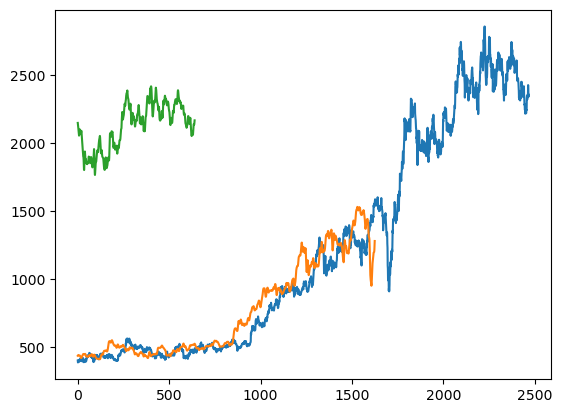

In [108]:
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [109]:
test = np.vstack((train_predict,test_predict))

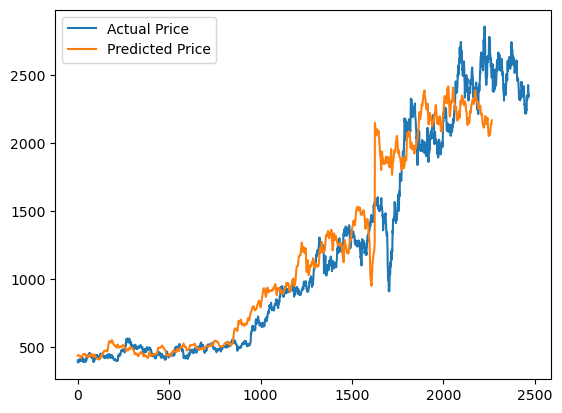

In [110]:
plt.plot(normalizer.inverse_transform(ds_scaled), label= 'Actual Price')
plt.plot(test, label= 'Predicted Price')
plt.legend()
plt.show()

In [111]:
len(ds_test)

741

In [112]:
fut_inp = ds_test[641:]

In [113]:
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)

In [114]:
fut_inp.shape

(1, 100)

In [115]:
tmp_inp = tmp_inp[0].tolist()

In [116]:
lst_output=[]
n_steps=100
i=0
while(i<5):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.7176081538200378], [0.7006115317344666], [0.6757069826126099], [0.6489394307136536], [0.623945415019989]]


In [117]:
len(ds_scaled)

2467

In [118]:
plot_new=np.arange(1,101)
plot_pred=np.arange(101,106)

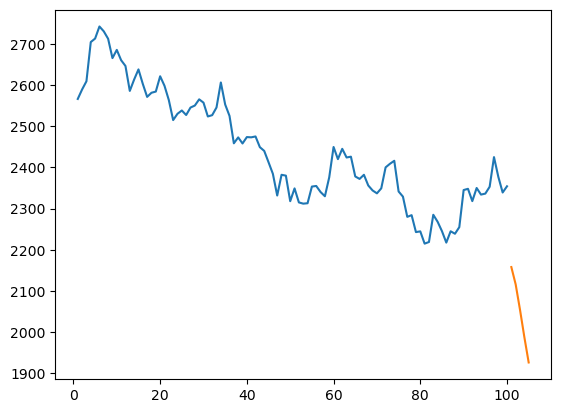

In [119]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[2367:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [120]:
ds_new = ds_scaled.tolist()

In [121]:
len(ds_new)

2467

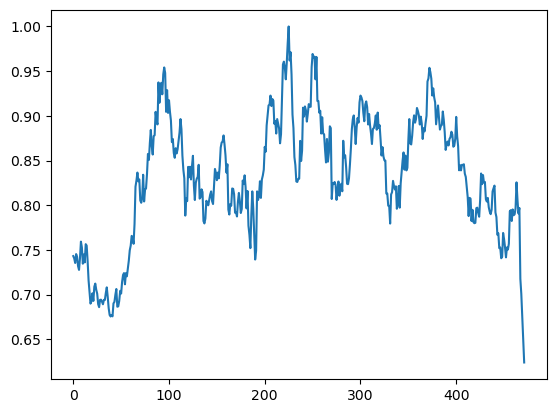

In [122]:
ds_new.extend(lst_output)
plt.plot(ds_new[2000:])

In [123]:
final_graph = normalizer.inverse_transform(ds_new).tolist()

# VISUALIZATION 

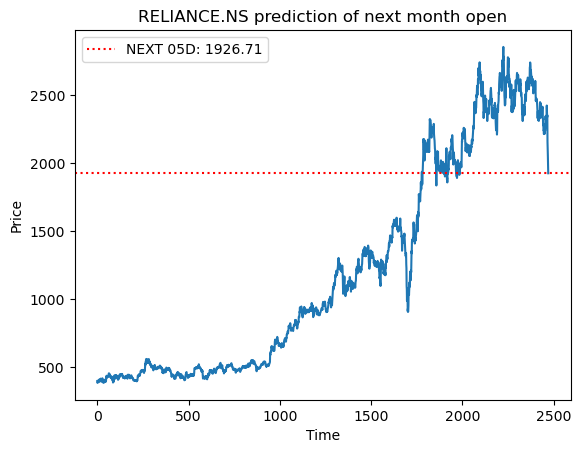

In [126]:
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 05D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

In [127]:
print(normalizer.inverse_transform(lst_output))

[[2158.20558796]
 [2116.19766207]
 [2054.64493419]
 [1988.48771007]
 [1926.71386149]]


In [128]:
model.save('stocks.h5')